In [19]:
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import jax.numpy as jnp
from jax.tree_util import Partial
key = jax.random.PRNGKey(83)

import jaxkd as jk
from scipy.spatial import KDTree

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Basic usage

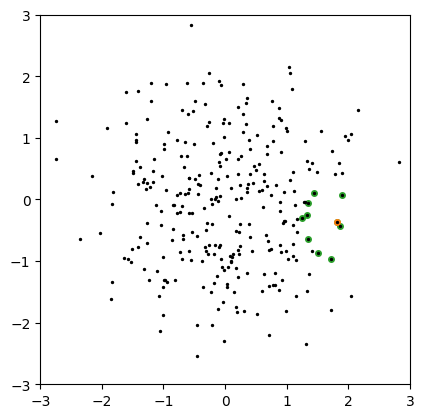

In [20]:
# Generate a few random points
n_points = 300
key, subkey = jax.random.split(key)
points = jax.random.normal(subkey, shape=(n_points, 2))
tree = jk.build_tree(points)
neighbors, distances = jk.query_neighbors(tree, points[0], 10)

# Plot
plt.scatter(*points[neighbors].T, s=16, c='C2')
plt.scatter(*points[0], s=16, c='C1')
plt.scatter(*points.T, s=2, c='k')
plt.gca().set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
plt.show()

## Gradients

One simple way to use the tree is to keep the locations of points fixed and optimize some function using neighbors. This could also be easily accomplished using a static neighbor array built with `scipy.spatial.KDTree`.

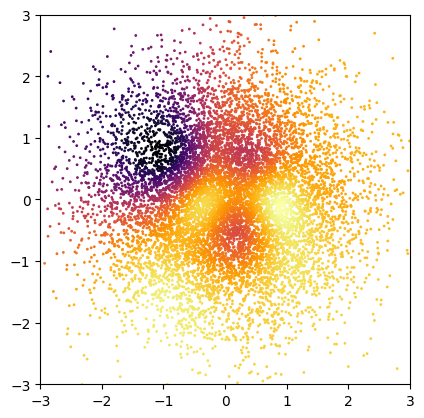

In [21]:
# Generate points and tree
n_points = 10_000
key, subkey = jax.random.split(key)
points = jax.random.normal(subkey, shape=(n_points, 2))
tree = jk.build_tree(points)
neighbors, distances = jk.query_neighbors(tree, points, k=20)

# Difference in values determined by distance to neighbors
def loss_func(values):
    difference = (values[:, None] - values[neighbors])**2
    return jnp.sum(difference - distances)

def step(values, _):
    loss, grad = jax.value_and_grad(loss_func)(values)
    values = values - 0.01 * grad
    return values, (values, loss)

# Optimize random initial values
key, subkey = jax.random.split(key)
values = jax.random.normal(subkey, shape=(n_points,))
values, (values_hist, loss_hist) = jax.lax.scan(step, values, None, length=200)

# Plot
plt.scatter(*points.T, c=values, s=1, cmap='inferno')
plt.gca().set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
plt.show()

In [ ]:
# Animate the optimization, values eventually propagate beyond immediate neighbors
fig, ax = plt.subplots(figsize=(5, 5))
s = ax.scatter(*points.T, c=values_hist[0], s=1, cmap='inferno')
ax.set(xlim=(-3, 3), ylim=(-3, 3))
def update(i):
    s.set_array(values_hist[i])
    s.set_clim(vmin=values_hist[i].min(), vmax=values_hist[i].max())
    return s,
ani = FuncAnimation(fig, update, frames=range(0, len(values_hist), 10), interval=1000/10, blit=True)
plt.close()
HTML(ani.to_jshtml())

A more fun way to use the tree is to allow points to move and dynamically update the neighbors at every step of the optimization. The entire loop can be JIT compiled and run on the GPU!

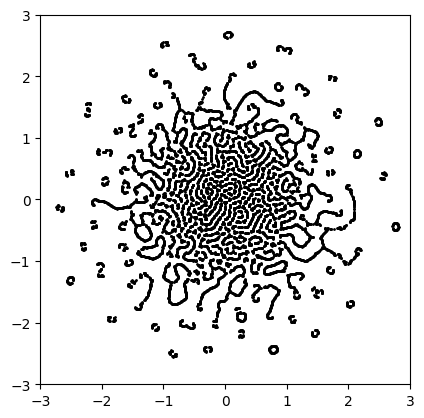

In [23]:
# Nearest neighbors at fixed distances -- the result depends strongly on k, the distance scale, and the number of points!
def loss_func(points):
    tree = jk.build_tree(points)
    neighbors, _ = jk.query_neighbors(tree, points, k=25)
    distances = jnp.linalg.norm(points[:,None] - points[neighbors][:,1:], axis=-1) # recompute without self-distance for finite gradient
    return jnp.sum(jnp.square(distances - 0.005 * jnp.arange(neighbors.shape[-1])[1:]))

@jax.jit
def step(points, _):
    loss, grad = jax.value_and_grad(loss_func)(points)
    points = points - 0.01 * grad
    return points, (points, loss)

# Optimize location of random initial points
n_points = 10_000
key, subkey = jax.random.split(key)
points = jax.random.normal(subkey, shape=(n_points, 2))
points, (points_hist, loss_hist) = jax.lax.scan(step, points, None, length=50)

# Plot
plt.scatter(*points.T, s=1, c='k')
plt.gca().set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
plt.show()

In [ ]:
# Animate the optimization, points arrange themselves on lines with equal spacing
fig, ax = plt.subplots(figsize=(5, 5))
s = ax.scatter(*points_hist[0].T, s=1, c='k')
ax.set(xlim=(-3, 3), ylim=(-3, 3))
def update(i):
    s.set_offsets(points_hist[i])
    return s,
ani = FuncAnimation(fig, update, frames=range(0, len(points_hist)), interval=1000/10, blit=True)
plt.close()
HTML(ani.to_jshtml())

## Clustering

The ability to dynamically build a tree within JIT also enables us to write iterative algorithms like $k$-means easily. We just have to use `segment_sum` to compute the mean with a variable number of points per cluster.

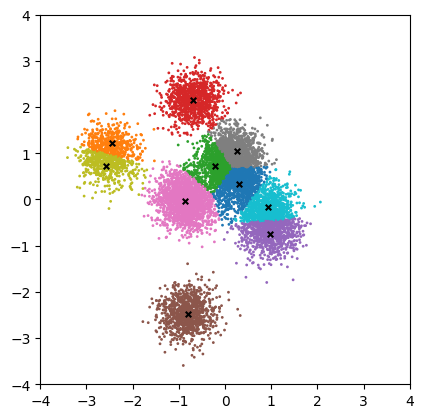

In [65]:
# Make mock cluster data
n_clusters = 10
n_points_per_cluster = 1_000
key, *subkeys = jax.random.split(key, 4)
points = (
    jax.random.normal(subkeys[0], shape=(n_clusters, 2)) # cluster center
    + 0.3 * jax.random.normal(subkeys[1], shape=(n_points_per_cluster, n_clusters, 2)) # cluster spread
).reshape(-1, 2)
means = jax.random.choice(subkeys[2], points, shape=(n_clusters,)) # initial means

# Run a few k-means iterations (see how simple the code is!)
n_iterations = 50
def k_means_step(means, _):
    tree = jk.build_tree(means)
    nearest_center = jk.query_neighbors(tree, points, 1)[0].squeeze(-1)
    segment_mean = lambda d, i, n: jax.ops.segment_sum(d, i, n) / jax.ops.segment_sum(jnp.ones_like(d), i, n)
    means = segment_mean(points, nearest_center, len(means))
    return means, (means, nearest_center)
means, (mean_hist, cluster_hist) = jax.lax.scan(k_means_step, means, length=50)

# Plot the result
plt.scatter(*points.T, c=cluster_hist[-1], s=1, cmap='tab20', vmin=0, vmax=n_clusters)
plt.scatter(*means.T, c='k', s=16, marker='x')
plt.gca().set(xlim=(-4, 4), ylim=(-4, 4), aspect='equal')
plt.show()

In [ ]:
# Animate k-means iterations
fig, ax = plt.subplots(figsize=(5, 5))
s1 = ax.scatter(*points.T, c=cluster_hist[0], s=1, cmap='tab20', vmin=0, vmax=n_clusters)
s2 = ax.scatter(*means.T, c='k', s=16, marker='x')
ax.set(xlim=(-4, 4), ylim=(-4, 4))
def update(i):
    s1.set_array(cluster_hist[i])
    s2.set_offsets(mean_hist[i])
    return s1, s2
ani = FuncAnimation(fig, update, frames=range(0, n_iterations), interval=1000/10, blit=True)
plt.close()
HTML(ani.to_jshtml())

## Scale to more points

For large numbers of points, it is *highly* recommended to run on GPU. Operations are automatically compiled, so run a second time to see the compiled speed. On my laptop, tree construction is slightly faster than `scipy.spatial.KDTree` due to fast GPU sorts, whereas querying is several times slower. Unsurprisingly, an H100 can beat my laptop CPU with roughly 0.8 s build / 0.2 s query for 10M points / 1M query, or 10 s build / 2 s query for 100M points / 10M query. Obviously an XLA-based tree code is not the answer if performance is the only factor, but it is fast enough to be usable where JAX compatibility is important.

In [33]:
# Sample points
n_points = 10_000_000
n_queries = 1_000_000
key, *subkey = jax.random.split(key, 3)
points = jax.random.normal(subkey[0], shape=(n_points, 3))
queries = jax.random.normal(subkey[1], shape=(n_queries, 3))

In [34]:
# Build tree
tree = jk.build_tree(points)
tree.indices

Array([4866510, 1085406, 1078138, ..., 9016864, 9835554, 8029913], dtype=int32)

In [35]:
# Find neighbors for all points
neighbors, distances = jk.query_neighbors(tree, queries, 4)
neighbors

Array([[1081156, 3971893, 7959301, 6942895],
       [1154566, 4074102, 8965114, 3178592],
       [5485643, 2135750,  660947, 5756418],
       ...,
       [3228255, 3298715, 3036420, 6219730],
       [7041777, 7647930, 2982552, 6844293],
       [9585620, 5994017, 7600727, 4308251]], dtype=int32)

In [36]:
# Build scipy KDTree to compare
scipy_tree = KDTree(points)

In [37]:
# Find neighbors for all points again
scipy_neighbors = scipy_tree.query(queries, k=4, workers=-1)[1]
scipy_neighbors

array([[1081156, 3971893, 7959301, 6942895],
       [1154566, 4074102, 8965114, 3178592],
       [5485643, 2135750,  660947, 5756418],
       ...,
       [3228255, 3298715, 3036420, 6219730],
       [7041777, 7647930, 2982552, 6844293],
       [9585620, 5994017, 7600727, 4308251]], shape=(1000000, 4))

In [ ]:
# Do all points match? Sometimes floating point errors seem to cause a tiny difference
jnp.sum(neighbors == scipy_neighbors) / neighbors.size

Array(1., dtype=float32)